In [1]:
from cmath import nan
from timeit import repeat
from tkinter import Y

import numpy as np
import skimage
from skimage.io import imread
from skimage.measure import block_reduce
import os
from matplotlib import pyplot as plt
from matplotlib import cm
import pickle
import json
import scipy.io as scio
import pickle
from scipy import signal
from skimage import restoration

from pathlib import Path

from suite2p.extraction import dcnv


In [2]:
# Absolute path to the JSON file
file_path = Path(r'C:/Users/Conor/2Psinapod/2Psinapod/config_widefield.json')

# Load JSON file
with file_path.open('r') as f:
    config = json.load(f)

In [3]:
BASE_PATH = config['RecordingFolder'] # folder with all of the files required to process recording. 
TIFF_PATH = config['TIFF']
CSV_PATH = config['Triggers'] # name of CSV (assumed to be in the folder given in line above) with the trigger voltages over the recording
CONDITIONS_PATH = config['Conditions'] # name of the CSV (assumed to be in folder given two lines above) with the condition types of each trial (freq, intensity, etc)
TIFF = BASE_PATH + TIFF_PATH

STIMULUS_FRAMERATE = config['TriggerFR'] # framerate of the trigger file
TRIGGER_DELAY_IN_MS = config['TriggerDelay'] # delay between TDT sending a trigger and the stimulus actually happening
RECORDING_FRAMERATE = config['RecordingFR'] # framerate of the fluorescence recording
EPOCH_START_IN_MS = config['EpochStart'] # time to include before trial onset for each epoch
EPOCH_END_IN_MS = config['EpochEnd'] # time to include after trial onset for each epoch
NO_BASELINE_FRAMES = config['BaselineFrames']
ZSCORE_THRESHOLD = config['ZscoreThreshold']
START = config['ResponseStart']
STOP = config['ResponseStop']

In [4]:
## PRE-PROCESSING ##

'''
Load the tiff stack of the recording as a single 3D array and downsample it from 512x512 to 256x256 (if recording is larger than 512x512, change block size).   
Note: The tiff stack must be the only thing in the folder.  It will try to load other items into the array.
@Param: Name of folder (paste path into FILESTOLOAD section)
Return: (N_frames x N_pixels x N_pixels) numpy array.
'''
def load_recording(TIFF):

        video = []
        images = [img for img in os.listdir(TIFF)]

        for img in images:
                im = imread(TIFF+img)
                downsamp_img = block_reduce(im,block_size=(2,2),func=np.mean)
                video.append(downsamp_img)
        video = np.array(video)

        return video

In [5]:
def get_onset_frames(stimulus):
    # find the max voltage (this will be the value in the vector when the trigger was sent)
    max_voltage = max(stimulus, key=lambda x:x[1])
    max_voltage = max_voltage[1]

    onset_times = [] # empty list to append our onset frames into
    time_list_index = 0 # counter to keep track of our index in the onset_times list

    # for each frame in the stimulus file
    for stimulus_idx in range(len(stimulus)):
        (time,voltage) = stimulus[stimulus_idx] # unpack the voltage at that timepoint

        if voltage.round() == max_voltage.round(): # if the voltage was our trigger voltage
            if time_list_index == 0: # and if we're at the first index (so there's no previous index to compare with)
                trigger_time_in_sec = time/1000 + TRIGGER_DELAY_IN_MS/1000
                onset_times.append(trigger_time_in_sec) # add the time as an onset time in SECONDS
                time_list_index += 1

            # if we're not at index zero, we need to compare this voltage with the previous saved onset voltage
            # otherwise we save a bunch of voltages as separate triggers because they all match the max voltage
            # but we just want one timepoint per trigger
            elif time/1000 -  onset_times[time_list_index - 1] > 1: 
                trigger_time_in_sec = time/1000 + TRIGGER_DELAY_IN_MS/1000
                onset_times.append(trigger_time_in_sec) # want it in second not millisecond
                time_list_index += 1

    # get the onset times in terms of frames of our fluorescence trace
    onset_frames_at_recording_fr = np.multiply(onset_times,RECORDING_FRAMERATE) # s * f/s = f

    #Remove first three triggers, corresponding to start at frame zero, 
    onset_frames_at_recording_fr = onset_frames_at_recording_fr[3:]

    return onset_frames_at_recording_fr

In [6]:
'''
Applies a Butterworth high pass filter to the full time-course of each pixel, to remove slow fluctuations in the signal. 
@Param: Cutoff - The frequency below which activity will be filtered out of the signal. 
@Param: fs - framerate of the recording in Hz
@Param: The order of the filter. For 'bandpass' and 'bandstop' filters, the resulting order of the final second-order 
@Param: Video - 
sections ('sos') matrix is 2*N, with N the number of biquad sections of the desired system.
'''


def butter_highpass(cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = signal.butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(video, cutoff, fs, order):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = signal.filtfilt(b, a, video)
    return y

def apply_butter_highpass(video,cutoff,fs):
        video_filtered = np.zeros_like(video)
        for i in range(len(video[0,:,0])):
                for j in range(len(video[0,0,:])):
                        video_filtered[:,i,j] = butter_highpass_filter(video[:,i,j],cutoff,fs,order)
        return video_filtered


In [10]:
# Gaussian denoise



In [7]:
def epoch_trials(video,onset_frames):

        # Get length of trial in seconds
        trial_length_in_ms = EPOCH_END_IN_MS - EPOCH_START_IN_MS # this gives us length in ms
        trial_length_in_sec = trial_length_in_ms/1000 # now we have it in second

        # Convert this to length in frames
        trial_length_in_frames = int(trial_length_in_sec * RECORDING_FRAMERATE) # s * f/s = f

        # Initialize an array to store the epoched traces
        # nTrials x nFrames x nPixels x nPixels

        epoched_pixels = np.zeros((len(onset_frames),(trial_length_in_frames), len(video[0,:,0]), len(video[0,0,:])))

        #Start filling the empty matrix:
        # Loop through the onset frames
        for onset in range(len(onset_frames)-1):

                #Get the trial starting and ending frames
                trial_starting_frame = np.round(onset_frames[onset]) + (EPOCH_START_IN_MS/1000*RECORDING_FRAMERATE)
                trial_ending_frame = np.round(onset_frames[onset]) + (EPOCH_END_IN_MS/1000*RECORDING_FRAMERATE)


                #Grab this range of frames from the recording and store in epoched matrix
                epoch = video[int(trial_starting_frame):int(trial_ending_frame),:,:]
                epoched_pixels[onset,:,:] = epoch

        return epoched_pixels

In [8]:
def get_pixel_baseline(pixel_trace,onset_frames):
    
    baselines = np.empty(len(onset_frames)) 

    for i, idx in enumerate(onset_frames):
        start_idx = max(0, idx - 5)
        end_idx = idx  # Don't Include the value at the onset frame.
        baseline_frames = pixel_trace[int(start_idx): int(end_idx)]

        baselines[i] = np.mean(baseline_frames)

    pixel_baseline = np.mean(baselines)
    
    return pixel_baseline

In [10]:
# convert to delta f / f0 

def convert_deltaF_F0(video,onset_frames):

    deltaF_F0_converted = np.zeros_like(video) 

    # For each pixel, use the onset frames to get all the pre-stimulus baseline values - the mean of this is F0
    for i in range(len(video[0,:,0])):
        for j in range(len(video[0,0,:])):

            trace = np.array(video[:,i,j])

            pixel_baseline = get_pixel_baseline(trace,onset_frames)

            deltaF_F0 = ((trace - pixel_baseline)/pixel_baseline)

            deltaF_F0_converted[:,i,j] = deltaF_F0
    
    return deltaF_F0_converted

In [11]:
def convert_to_deltaF_Fo_singlemean(video):
        # Takes a single pixel mean for whole pixel's trace - only really good for visualization. 
        # Take the mean of each pixel across all frames and store it in a 256x256 ndarray. 
        mean_pixels = np.empty(shape=[256,256])

        for i in range(len(video[0,:,0])):
                for j in range(len(video[0,0,:])):

                        mean = np.mean(video[:,i,j])
                        mean_pixels[i,j] = mean

        #For each frame, subtract the mean of that frame from the total recording, 
        # then divide by the mean to get (F-Fo)/Fo

        #Reshape array so can subtract mean value
        mean_pixels = mean_pixels[np.newaxis,...]
        baseline_subtracted = (np.subtract(video,mean_pixels))
        deltaF_Fo_singlemean = baseline_subtracted/mean_pixels

        return deltaF_Fo_singlemean

In [12]:
def format_trials(baseline_adjusted_epoched,conditions):

        #Format the trials into a dict, arranged by frequency.
        #Each trace should be a nFrames by relative fluorescence array
        # format the dictionary so we get this structure:
        #     # freq_f{
        #       repetition{ 
        #           [x,x,x,x,...] }}}

        freq_dict = dict.fromkeys(np.unique(conditions[:,0]))

        # make empty dictionaries so we can index properly later
        for freq in freq_dict:
                freq_dict[freq] = {}

        # make a temporary map so we can keep track of how many repetitions of this trial we've seen
        # just going to add together the frequency and intensity to index it
        # biggest element we'll need is max(frequency)
        max_element = max(conditions[:,0]) + 10
        temp_map = [0] * max_element

        # for each trial
        for trial in range(len(conditions)):

                # trial's frequency
                f = conditions[trial,0]

                # access the map to see how many repetitions of the frequency we've already seen
                # this way we don't overwrite a trial with the same stimulus type
                num_rep = temp_map[f]+1
                temp_map[f] += 1

                # using the frequency and intensity to index our dictionary to store our trace
                freq_dict[f][num_rep] = baseline_adjusted_epoched[trial,:,:,:]

        return freq_dict


In [55]:
def get_zscored_response(trial,onset_frames):
    baseline = get_pixel_baseline(trial,onset_frames)
    #response = trial[n_baseline_frames:]

    baseline_mean = np.average(baseline)
    baseline_std = np.std(baseline)

    zscorer = lambda x: (x-baseline_mean)/baseline_std
    zscore_response = np.array([zscorer(xi) for xi in trial])

    return zscore_response


def zscore_and_median(freq_dict,conditions,onset_frames):
        # Create the empty dictionary that will store median values
        median_zscore_dict = dict.fromkeys(np.unique(conditions[:,0]))

        for freq in freq_dict:
                # Create empty numpy arrays to store each individual trial, it's z-scored version, the average value of the response period,
                #  and the median value across all trials. 
                freq_array = np.empty([len(freq_dict[freq]),25,256,256])
                zscore_array = np.empty([len(freq_dict[freq]),25,256,256])
                ave_zscore_array = np.empty([len(freq_dict[freq]),256,256])
                median_zscore_array = np.empty([1,256,256])
                median_zscore_dict[freq] = {}


                #  Iterate through each rep in the given frequency key and convert it to a z-score.
                for rep in range(1,len(freq_dict[freq])):
                        freq_array[rep-1,:,:,:] = freq_dict[freq][rep]
                        for i in range(len(freq_array[0,0,:,0])):
                                for j in range(len(freq_array[0,0,0,:])):
                                        zscore_array[rep-1,:,i,j] = get_zscored_response(freq_array[rep-1,:,i,j],onset_frames)
                                        # Extract the frames corresponding to the response period and find the mean value. 
                                        ave_zscore_array[rep-1,i,j] = np.mean(zscore_array[rep-1,START:STOP,i,j])
                #  iterate through the mean values for each pixel, and find the median value across all trials for that pixel. 
                for i in range(len(ave_zscore_array[0,:,0])):
                        for j in range(len(ave_zscore_array[0,0,:])):
                                median_zscore_array[:,i,j] = np.median(ave_zscore_array[:,i,j])

                median_zscore_dict[freq] = median_zscore_array

        return median_zscore_dict

In [53]:
def convert_to_zscore(freq_dict,conditions,onset_frames):
    
        zscore_dict = dict.fromkeys(np.unique(conditions[:,0]))
        
        for freq in freq_dict:
                
                # Create empty numpy arrays to store each individual trial, it's z-scored version, the average value of the response period,
                #  and the median value across all trials. 
                freq_array = np.empty([len(freq_dict[freq]),25,256,256])
                zscore_array = np.empty([len(freq_dict[freq]),25,256,256])

                 #  Iterate through each rep in the given frequency key and convert it to a z-score.
                for rep in range(1,len(freq_dict[freq])):
                        freq_array[rep-1,:,:,:] = freq_dict[freq][rep]
                        for i in range(freq_array.shape[2]):
                                for j in range(freq_array.shape[3]):
                                        zscore_array[rep-1,:,i,j] = get_zscored_response(freq_array[rep-1,:,i,j],onset_frames)

                zscore_dict[freq] = zscore_array

        return zscore_dict


EXECUTION CODE:

In [18]:
stimulus = np.genfromtxt(BASE_PATH + CSV_PATH,delimiter=',',skip_header=True) # voltage values of the trigger software over the recording
conditions_mat = scio.loadmat(BASE_PATH + CONDITIONS_PATH) # conditition type of each trial in chronological order
conditions = conditions_mat["stim_data"]
conditions = conditions[3:]  #Remove the first silent stim as this corresponds to frame 0

onset_frames = np.round(get_onset_frames(stimulus))

In [19]:
#Load the recording to be analyzed as a Nframes x Xpixels x Ypixels array. 
video = load_recording(TIFF)

In [20]:
#Apply Butterworth highpass filter 

cutoff = 0.3
fs = 10
order = 5

video_high_filtered = apply_butter_highpass(video,cutoff,fs)

In [65]:
# #Convert to deltaF/F0
# delta_F = convert_deltaF_F0(video_high_filtered,onset_frames)

#Convert to deltaF/F0 single mean
delta_F = convert_to_deltaF_Fo_singlemean(video)

In [38]:
# Epoch the recording into trials

epoched = epoch_trials(video_high_filtered,onset_frames)

In [39]:
# Format into dictionary

freq_dict = format_trials(epoched,conditions)

In [24]:
# zscore_dict = convert_to_zscore(freq_dict,conditions)

In [25]:
# # save the recording information 
# with open(BASE_PATH+"zscore_dict.pkl",'wb') as f:
#         pickle.dump(zscore_dict,f)

In [42]:
with open(BASE_PATH+"deconv_test.pkl", 'rb') as f:
                deconv_test = pickle.load(f)

In [62]:
print(deconv_test[12335][5])

[[[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         1.20927799 0.        ]
  [0.15936978 0.         0.         ... 0.         0.         0.        ]
  ...
  [2.42692685 0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.72555369 0.         ... 0.         0.         0.        ]
  ...
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.         0.         ... 0.         0.         0.        ]]

 [[0.         0.         0.         ... 0.         0.         0.        ]
  [0.         0.      

In [64]:
# Take the epoched, formatted dictionary and convert each individual trial to a z-score. 
median_zscore_dict = zscore_and_median(deconv_test,conditions,onset_frames)

KeyboardInterrupt: 

In [44]:
test_freq = deconv_test[12335][1]
print(test_freq[:,40,150])

[ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.9388026
  0.          8.25631809 16.04413414  0.          0.          0.
  0.        ]


In [46]:
# save the recording information 
with open(BASE_PATH+"median_zscore_dict_deconv_test.pkl",'wb') as f:
        pickle.dump(median_zscore_dict,f)

UNUSED CODE

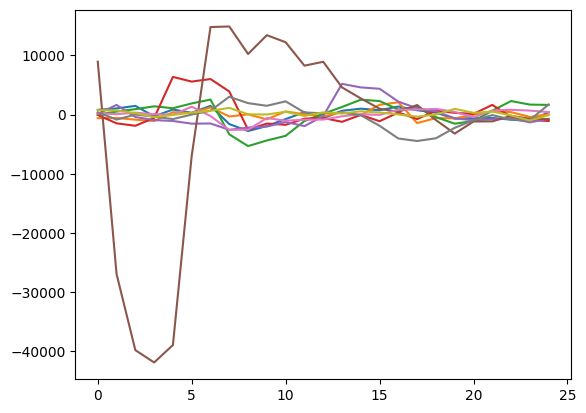

In [37]:
for i in range(1,10):
    test_freq = freq_dict[12335][i]
    plt.plot(test_freq[:,150,150])

In [30]:
# from math import pi, sqrt, exp

# def gauss(n=3000,sigma=470):
#     r = range(-int(n/2),int(n/2)+1)
    
#     return [1 / (sigma * sqrt(2*pi)) * exp(-float(x)**2/(2*sigma**2)) for x in r]

In [31]:
# def lucy_filter(video,repeats,psf):
#     filtered = np.zeros_like(video)
#     psf_array = np.full((5, 5), psf)
#     for frame in range(len(video[:,0,0])):
#         filtered[frame,:,:] = restoration.richardson_lucy(video[frame,:,:],psf_array,repeats)
#     return filtered


In [32]:
# skimage.io.imsave('test2.tiff', video_high_filtered,photometric='minisblack')

In [33]:
# def calc_psf(wavelength,NA,pw):
#     d = wavelength/ 2*NA
#     psf = d / (pw*1000)
#     return psf


In [34]:
# import numpy as np

# def makeGaussian2(x_center=0, y_center=0, theta=0, sigma_x = 470, sigma_y=470, x_size=2821, y_size=2821):
#     # x_center and y_center will be the center of the gaussian, theta will be the rotation angle
#     # sigma_x and sigma_y will be the stdevs in the x and y axis before rotation
#     # x_size and y_size give the size of the frame 

#     theta = 2*np.pi*theta/360
#     x = np.arange(0,x_size, 1, float)
#     y = np.arange(0,y_size, 1, float)
#     y = y[:,np.newaxis]
#     sx = sigma_x
#     sy = sigma_y
#     x0 = x_center
#     y0 = y_center

#     # rotation
#     a=np.cos(theta)*x -np.sin(theta)*y
#     b=np.sin(theta)*x +np.cos(theta)*y
#     a0=np.cos(theta)*x0 -np.sin(theta)*y0
#     b0=np.sin(theta)*x0 +np.cos(theta)*y0

#     return np.exp(-(((a-a0)**2)/(2*(sx**2)) + ((b-b0)**2) /(2*(sy**2))))

In [35]:
# import numpy as np
# from numpy.fft import fftn, ifftn, fftshift 

# def richardson_lucy_np(image, psf, num_iters):
    
#     otf = fftn(fftshift(psf))
#     otf_ = np.conjugate(otf)    
#     estimate = image#np.ones(image.shape)/image.sum()

#     for i in range(num_iters):
#         #print(i)
        
#         reblurred = ifftn(fftn(estimate) * otf)
#         ratio = image / (reblurred + 1e-30)
#         estimate = estimate * (ifftn(fftn(ratio) * otf_)).astype(float)
        

#     return estimate


In [36]:
# psf = np.full((256,256),0.0024)
# test = richardson_lucy_np(video_high_filtered[50,:,:],psf,300)

# plt.imshow(test)